In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scipy.fftpack import dct
import torch as torch

# Intro
This is a code to create training data for VAE (as well as other models). The code aligns the neural and vocal data.
- Input: existing neural_data_0_30k.bin which is processed spike data in 30k bin. This is obtained from step 1 clean raw data
- Input: user choose 'choice' of which neural and vocal data to load. one at a time due to memory constraint
- Method: a few parameters you can choose in the middle of the code, including padding, pre and post padding, window size, step size, etc.
- Output: a folder with neural, vocal, and label data.

Note: you can bin the neural data into whatever Hz you want and different type of sliding windows. But you can't do anything to vocal data because it is a spectrogram already in 250Hz (unless you convert it back to waveform and then do STFT again...)


In [2]:
# Choose which neural data to load (0, 1, or 2)
# choice = 0  # Uncomment this line to choose data 0
# choice = 1  # Uncomment this line to choose data 1 
choice = 2  # Uncomment this line to choose data 2

### Choose neural data, one at a time

In [3]:
# Set file path based on choice
file_path = rf"M:\neuro2voc\task-5\neural_data_{choice}_30k.bin"
print(f"You chose to load neural data {choice}")

You chose to load neural data 2


In [4]:
num_neurons = 75
data = np.fromfile(file_path, dtype=np.int16)
time_steps = data.size // num_neurons
data = data.reshape((num_neurons, time_steps))
print(f"Data shape: {data.shape}")
print(f"Data statistics: min={data.min()}, max={data.max()}, mean={data.mean()}")
print(f"Number of non-zero elements: {np.count_nonzero(data)}")

Data shape: (75, 126659769)
Data statistics: min=0, max=1, mean=0.0005285183595537217
Number of non-zero elements: 5020651


In [5]:
# memory constraint, only work one by one
# data_files = ['neural_data_0_30k.bin', 'neural_data_1_30k.bin', 'neural_data_2_30k.bin']
# data_list = []

# for file in data_files:
#     file_path = os.path.join(data_dir, file)
#     data = np.fromfile(file_path, dtype=np.int16)
#     time_steps = data.size // 75
#     data = data.reshape((75, time_steps))
#     data_list.append(data)

In [6]:
# Load and process annotations
annotation_dir = os.path.join("M:", "neuro2voc", "task-5")

# # Load spike data for chosen dataset

# Load and process annotations for chosen dataset
annotations_df = pd.read_csv(os.path.join(annotation_dir, f'annotations_raw_g{choice}_t0.nidq.bin.csv'))
annotations_df['onset'] = (annotations_df['onset']*1.5).astype(int)
annotations_df['duration'] = (annotations_df['duration']*1.5).astype(int)
df = annotations_df[annotations_df['cluster_id'].between(2, 8)]

print(df.tail())

print(f"You chose to load annotation data {choice}")

                    file      onset  duration  cluster_id
2912  raw_g2_t0.nidq.bin  123520929       999           6
2913  raw_g2_t0.nidq.bin  123522883      5908           7
2914  raw_g2_t0.nidq.bin  123529807      4758           3
2915  raw_g2_t0.nidq.bin  123534565      2287           4
2916  raw_g2_t0.nidq.bin  123536853      3852           5
You chose to load annotation data 2


In [7]:
# # Get last row's onset + duration
# df = pd.read_csv(os.path.join(data_dir, f'processed_spikes_{choice}_20k.csv'))
# last_row = df.iloc[-1]
# last_time = (last_row['onset'] + last_row['duration'])
# print(f"Last time point: {last_time}")

# # Trim data to last time point
# trimmed_data = data[:, :last_time]
# print(f"Original data shape: {data.shape}")
# print(f"Trimmed data shape: {trimmed_data.shape}")

# Create your neural + vocal + label dataset
this time we do neural and vocal together
my vocal data is a spectrogram of 250Hz
I bin the same Hz

In [8]:
# neural data is already loaded
data.shape
print(f"Neural data shape: {data.shape}")
df # if you ran the block at the very beginning, the onset here should be 30k now

Neural data shape: (75, 126659769)


,file,onset,duration,cluster_id
2,raw_g2_t0.nidq.bin,981984,1576,2
3,raw_g2_t0.nidq.bin,988002,1675,2
4,raw_g2_t0.nidq.bin,992247,5122,3
5,raw_g2_t0.nidq.bin,997369,1927,4
6,raw_g2_t0.nidq.bin,999657,3252,5
...,...,...,...,...
2912,raw_g2_t0.nidq.bin,123520929,999,6
2913,raw_g2_t0.nidq.bin,123522883,5908,7
2914,raw_g2_t0.nidq.bin,123529807,4758,3
2915,raw_g2_t0.nidq.bin,123534565,2287,4


In [9]:
# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()
df['onset'] = df['onset'] - 900
df
# now move it forward by 30ms

,file,onset,duration,cluster_id
2,raw_g2_t0.nidq.bin,981084,1576,2
3,raw_g2_t0.nidq.bin,987102,1675,2
4,raw_g2_t0.nidq.bin,991347,5122,3
5,raw_g2_t0.nidq.bin,996469,1927,4
6,raw_g2_t0.nidq.bin,998757,3252,5
...,...,...,...,...
2912,raw_g2_t0.nidq.bin,123520029,999,6
2913,raw_g2_t0.nidq.bin,123521983,5908,7
2914,raw_g2_t0.nidq.bin,123528907,4758,3
2915,raw_g2_t0.nidq.bin,123533665,2287,4


In [10]:
spectrogram_dir = r"M:\neuro2voc\task-5"
spectrogram_path = r"M:\neuro2voc\task-5\frequencies.spec.npy"
raw_frequencies = np.load(spectrogram_path)
frequencies = raw_frequencies[0]

spec = np.load(f'{spectrogram_dir}\\raw_g{choice}_t0.nidq.bin.spec.npy')
print(f"Original spec shape: {spec.shape}")

padding = 4  # 16ms * 250Hz = 40 samples
spec = np.pad(spec, ((0, 0), (padding, 0)), mode='constant')
print(f"Padded spec shape: {spec.shape}")

print(f"You loaded the spectrogram {choice}")

Original spec shape: (128, 1168431)
Padded spec shape: (128, 1168435)
You loaded the spectrogram 2


In [11]:
print(data.shape[1]/spec.shape[1]) # make sure neural and spectrogram assumptions are right, should be close to 120 here

108.40121102158015


In [12]:
df['onset_spec'] = (df['onset'] + 900) // 120
df['duration_250Hz'] = df['duration'] // 120 # now it is 250Hz
print("First few rows with new onset_spec column:")
print(df.head())

First few rows with new onset_spec column:
                 file   onset  duration  cluster_id  onset_spec  \
2  raw_g2_t0.nidq.bin  981084      1576           2        8183   
3  raw_g2_t0.nidq.bin  987102      1675           2        8233   
4  raw_g2_t0.nidq.bin  991347      5122           3        8268   
5  raw_g2_t0.nidq.bin  996469      1927           4        8311   
6  raw_g2_t0.nidq.bin  998757      3252           5        8330   

   duration_250Hz  
2              13  
3              13  
4              42  
5              16  
6              27  


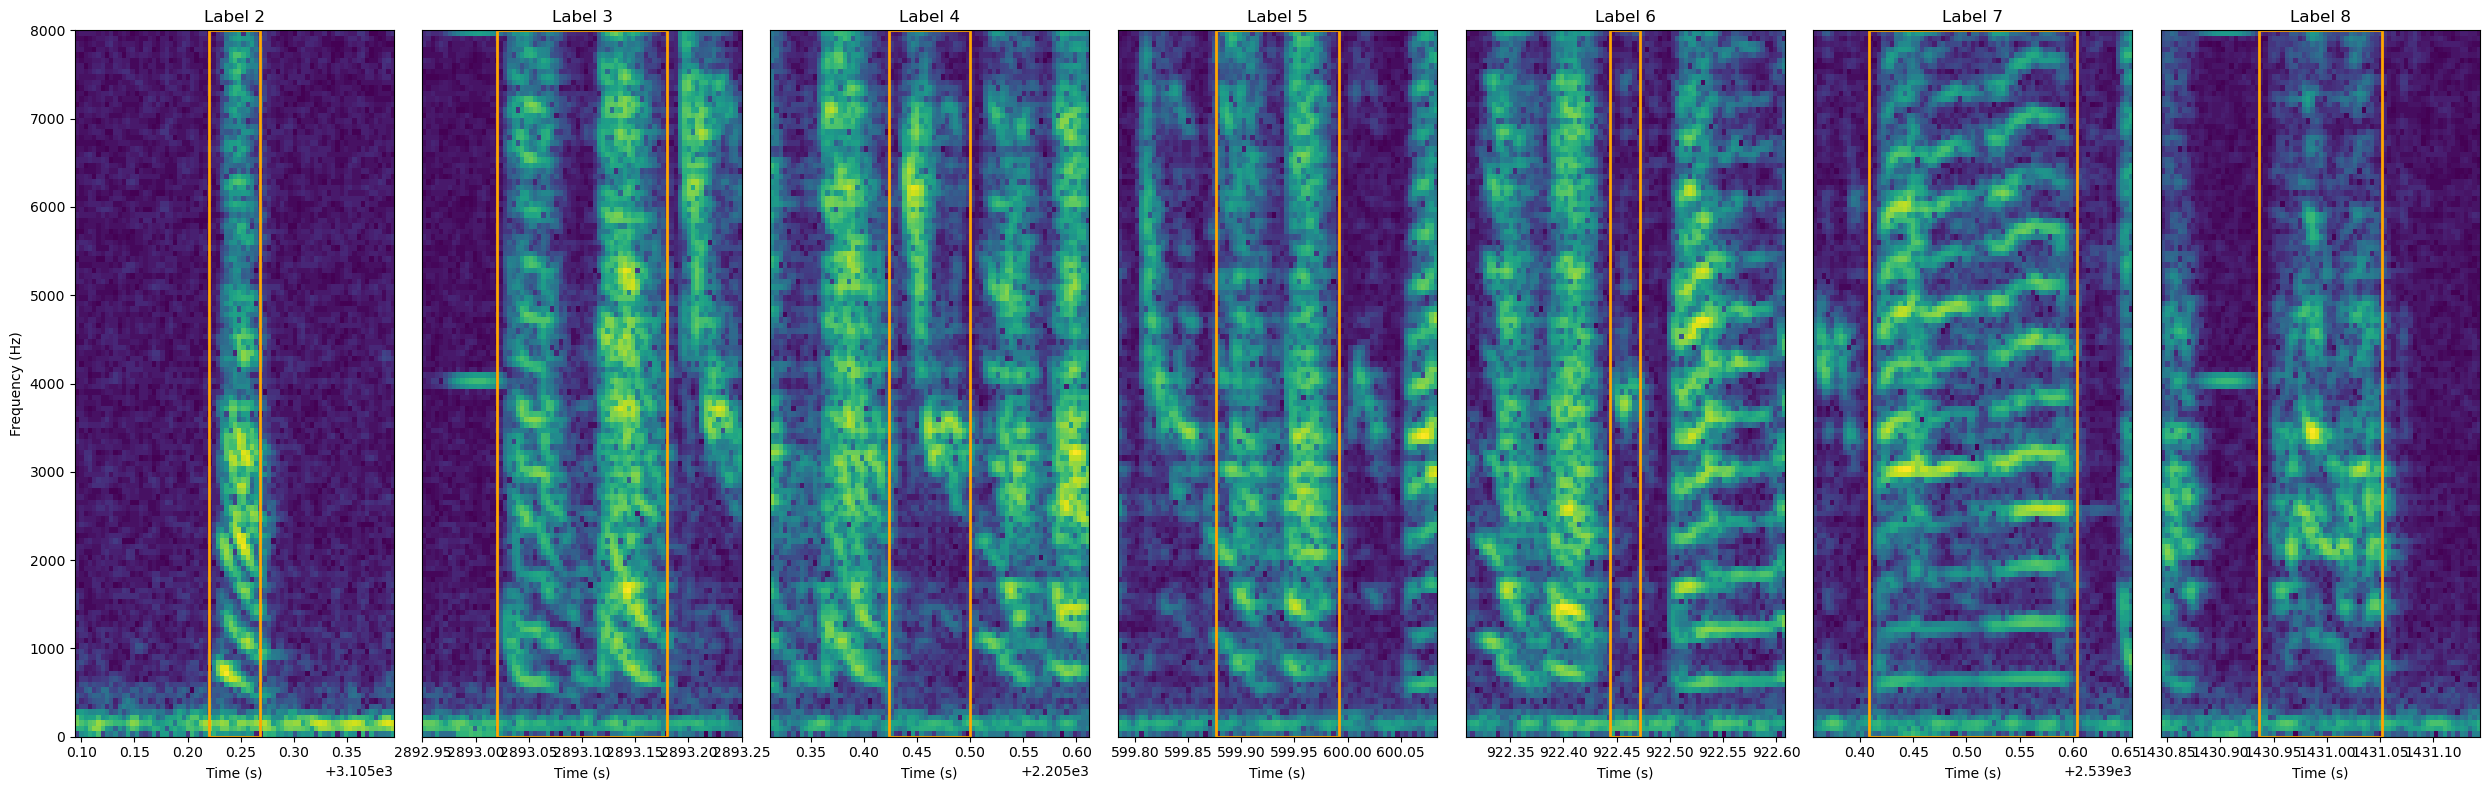

In [13]:
# Create a figure with subplots for labels 2-8 horizontally
fig, axs = plt.subplots(1, 7, figsize=(25, 8))

# Get all unique labels from 2-8
labels = list(range(2, 9))

# Plot one random example for each label 2-8
for label_idx, label in enumerate(labels):
    # Get all rows for this label
    label_data = df[df['cluster_id'] == label]
    if len(label_data) == 0:
        # If no data for this label, plot empty subplot
        axs[label_idx].set_title(f'Label {label}\n(No data)')
        continue
        
    # Get random row for this label
    row = label_data.iloc[np.random.randint(len(label_data))]
    
    onset = row['onset_spec']
    duration = row['duration_250Hz']
    
    # Calculate center and display window
    center_time = onset/250 + (duration/250) / 2
    display_start = max(0, center_time - 0.15)
    display_end = min(spec.shape[1]/250, display_start + 0.3)
    
    if display_end == spec.shape[1]/250:
        display_start = max(0, display_end - 1)
    
    # Get spectrogram slice
    start_index = int(display_start * 250)
    end_index = int(display_end * 250)
    sample_data = spec[:, start_index:end_index]
    
    # Plot spectrogram
    im = axs[label_idx].imshow(sample_data, aspect='auto', origin='lower',
                              extent=[display_start, display_end, frequencies[0], frequencies[-1]])
    
    # Add rectangle marking the vocalization with thicker linewidth and orange color
    rect = plt.Rectangle((onset/250, frequencies[0]), duration/250, frequencies[-1] - frequencies[0],
                        fill=False, edgecolor='orange', linewidth=2)
    axs[label_idx].add_patch(rect)
    
    # Labels and title
    if label_idx == 0:  # Only show y-label for leftmost plot
        axs[label_idx].set_ylabel('Frequency (Hz)')
    else:
        axs[label_idx].set_yticks([])
    
    axs[label_idx].set_xlabel('Time (s)')
    axs[label_idx].set_title(f'Label {label}')
    
plt.tight_layout()
plt.show()


For annotation with onset=71499585 (595837@250Hz), duration=2287@30kHz (19@250Hz):
Neural segment shape before binning: (75, 2287)
Binned neural data shape: (75, 19)
Spectrogram segment shape: (128, 19)


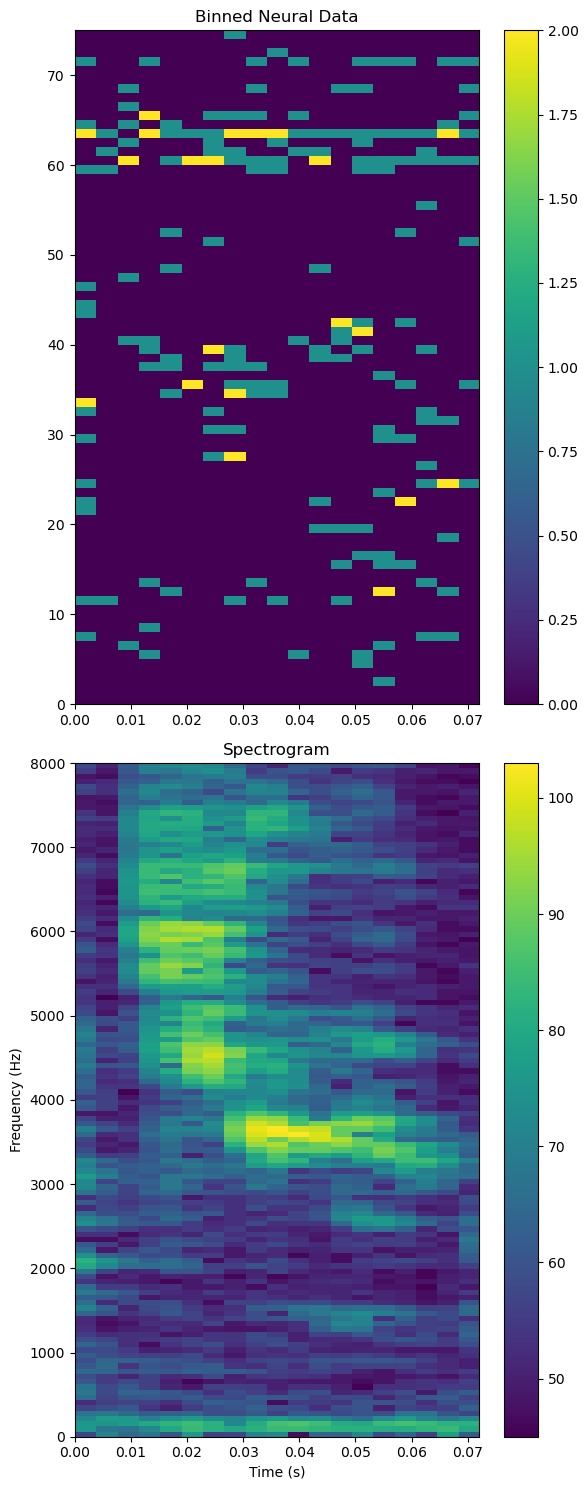

In [14]:
# plot something to test
test_annotation = df.iloc[np.random.randint(len(df))]
onset = test_annotation['onset']  # for neural, shifted forward by 30ms already
onset_spec = test_annotation['onset_spec']
duration_neural = test_annotation['duration']
duration_spec = duration_neural // 120  # Convert to 250Hz timebase consistently

# extract spec data
spec_start = onset_spec
spec_end = onset_spec + duration_spec  # Use duration_spec instead of duration
spec_segment = spec[:, spec_start:spec_end]
spec_time = np.arange(spec_segment.shape[1])/250

# extract neural data
neural_start = onset
neural_end = onset + duration_neural
neural_segment = data[:, neural_start:neural_end]

# bin neural data to 250Hz
bin_size = 120  # 30000/250 = 120
num_bins = neural_segment.shape[1] // bin_size
binned_neural = np.zeros((data.shape[0], num_bins))

for i in range(num_bins):
    bin_start = i * bin_size
    bin_end = (i + 1) * bin_size
    binned_neural[:, i] = np.sum(neural_segment[:, bin_start:bin_end], axis=1)

neural_time = np.arange(binned_neural.shape[1])/250

print(f"\nFor annotation with onset={onset} ({onset_spec}@250Hz), duration={duration_neural}@30kHz ({duration_spec}@250Hz):")
print(f"Neural segment shape before binning: {neural_segment.shape}")
print(f"Binned neural data shape: {binned_neural.shape}")
print(f"Spectrogram segment shape: {spec_segment.shape}")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 15))

im1 = ax1.imshow(binned_neural, aspect='auto', interpolation='nearest',
                 extent=[neural_time[0], neural_time[-1], 0, binned_neural.shape[0]])
ax1.set_title('Binned Neural Data')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(spec_segment, aspect='auto', interpolation='nearest', origin='lower',
                 extent=[spec_time[0], spec_time[-1], frequencies[0], frequencies[-1]])
ax2.set_title('Spectrogram')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Now we are ready to process neural and speech data together

#### For this extract segment, decide how you want your neural data segments be
- original? set pre padding and post padding to zero
- with padding bothways? set pre and post 
- move neural data forward? set pre to some value and post to minus
each number represent 1 sample in 250hz (4ms)

In [15]:
# # choice 1 pad both ways by 40ms x 2
# pre = 10
# post = 10

# # choice  2 shift foward by 20ms
# pre = 5
# post = -5

# # choice 3 pad on the left by 5*4 = 20ms
# pre = 5
# post = 0

# choice 4 pad on the left and right by 5 points (20ms) x 2 = 40ms
pre = 5
post = 5

# or more...

In [16]:
def extract_segment(data, spec, onset, onset_spec, duration_neural, duration_spec, pre, post):
    """
    Extract and bin neural and spectrogram segments with padding before and after.
    only works for 250Hz data
    if you want binning at other hz you need to change 120 below and also some code above
    """
    # extract spec data with padding
    spec_start = max(0, onset_spec - pre)  # Go back 10 samples
    spec_end = min(spec.shape[1], onset_spec + duration_spec + post)  # Add 10 samples after
    spec_segment = spec[:, spec_start:spec_end]

    # extract neural data with padding
    neural_start = max(0, onset - (pre * 120))  # Go back 10 samples at 250Hz (x120 for 30kHz)
    neural_end = min(data.shape[1], onset + duration_neural + (post * 120))  # Add 10 samples at 250Hz
    neural_segment = data[:, neural_start:neural_end]

    # bin neural data to 250Hz
    bin_size = 120  # 30000/250 = 120
    num_bins = neural_segment.shape[1] // bin_size
    binned_neural = np.zeros((data.shape[0], num_bins))

    for i in range(num_bins):
        bin_start = i * bin_size
        bin_end = (i + 1) * bin_size
        binned_neural[:, i] = np.sum(neural_segment[:, bin_start:bin_end], axis=1)

    # Verify segments have same length
    assert binned_neural.shape[1] == spec_segment.shape[1], f"Segment lengths don't match: neural={binned_neural.shape[1]}, spec={spec_segment.shape[1]}"

    return binned_neural, spec_segment


In [17]:
def create_segments(data, spec, df, output_dir, window_size=10, step_size=1, pre=10, post=10):
    """Create overlapping segments from annotations."""
    neural_dir = os.path.join(output_dir, "neural")
    speech_dir = os.path.join(output_dir, "speech")
    label_dir = os.path.join(output_dir, "label")
    os.makedirs(neural_dir, exist_ok=True)
    os.makedirs(speech_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    # find the largest existing segment number and verify consistency
    segment_count = 0
    max_nums = []
    for dir_path in [neural_dir, speech_dir, label_dir]:
        if os.path.exists(dir_path):
            files = os.listdir(dir_path)
            if files:
                max_nums.append(max([int(f.split('.')[0]) for f in files]))
    if max_nums:
        if len(set(max_nums)) > 1:
            raise ValueError(f"Inconsistent max segment numbers found: {max_nums}")
        segment_count = max_nums[0] + 1
        print(f"Found {segment_count-1} existing segments, continuing from {segment_count}")
    start_from = segment_count
    
    # calculate total number of segments for progress bar
    total_segments = 0
    extra_padding_bothway = pre + post  # check extract_segment, there are 10 before and 10 after, I extended the period because otherwise too few data.
    for _, row in df.iterrows():
        duration_spec = row['duration_250Hz']
        padded_length = duration_spec + extra_padding_bothway
        possible_windows = max(0, padded_length - window_size + 1)
        num_windows = (possible_windows + step_size - 1) // step_size  # Ceiling division
        total_segments += num_windows

    
    pbar = tqdm(total=total_segments, desc="Creating segments")
    
    # the loop
    for _, row in df.iterrows():
        onset = row['onset'] # neural
        onset_spec = row['onset_spec']
        duration_neural = row['duration']
        duration_spec = row['duration_250Hz']
        label = row['cluster_id']
        
        # extract full segments
        binned_neural, spec_segment = extract_segment(
            data, spec, onset, onset_spec, duration_neural, duration_spec, pre, post)

        num_possible_windows = binned_neural.shape[1] - window_size + 1 
        # verify window lengths match
        # create overlapping windows with step size of 1
        for start_idx in range(0, num_possible_windows, step_size):
            end_idx = start_idx + window_size
            
            neural_window = binned_neural[:, start_idx:end_idx]
            spec_window = spec_segment[:, start_idx:end_idx]
            assert neural_window.shape[1] == spec_window.shape[1] == window_size, f"Window lengths don't match: neural={neural_window.shape[1]}, spec={spec_window.shape[1]}"

            # convert to tensor and save
            neural_tensor = torch.from_numpy(neural_window.copy()).to(torch.float32)
            spec_tensor = torch.from_numpy(spec_window.copy()).to(torch.float32)
            label_tensor = torch.tensor(label, dtype=torch.int64)
            
            neural_filename = os.path.join(neural_dir, f"{segment_count:06d}.pt")
            speech_filename = os.path.join(speech_dir, f"{segment_count:06d}.pt")
            label_filename = os.path.join(label_dir, f"{segment_count:06d}.pt")
            
            torch.save(neural_tensor, neural_filename)
            torch.save(spec_tensor, speech_filename)
            torch.save(label_tensor, label_filename)
            
            segment_count += 1
            pbar.update(1)
            
    pbar.close()
    print(f"Created {segment_count-start_from} segments")
    print(f"There are total {segment_count} data Now.")
    return

In [18]:
# creating data segments:
#  output_dir = os.path.join('M:', 'neuro2voc', 'task-5', 'AOI_250Hz_segment_step_size_1')
# create_segments(data, spec, df, output_dir, window_size=10, pre=pre, post=post)

In [19]:
# output_dir = os.path.join('M:', 'neuro2voc', 'task-5', 'AOI_250Hz_CEBRA')
# create_segments(data, spec, df, output_dir, window_size=1, pre=pre, post=post)

In [20]:
# output_dir = os.path.join('M:', 'neuro2voc', 'task-5', 'AOI_250Hz_20ms') # its actually 20 window size and 80ms
# create_segments(data, spec, df, output_dir, window_size=20, pre=pre, post=post)

In [21]:
# output_dir = os.path.join('M:', 'neuro2voc', 'task-5', 'AOI_250Hz_Window_40ms_Pre_20ms_Post_20ms')
# create_segments(data, spec, df, output_dir, window_size=10, pre=pre, post=post)

In [22]:
output_dir = os.path.join('M:', 'neuro2voc', 'task-5', 'AOI_250Hz_Window_80ms_Pre_20ms_Post_20ms')
create_segments(data, spec, df, output_dir, window_size=20, pre=pre, post=post)

Found 10828 existing segments, continuing from 10829


Creating segments: 100%|██████████| 52977/52977 [00:39<00:00, 1332.01it/s]

Created 52977 segments
There are total 63806 data Now.


# Visualize
Now the process is finished. You should visualize it. You can do it once the above code is done

In [23]:
def visualize_random_pair(output_dir):
    """Visualize 10 consecutive pairs of neural and speech data with their labels."""
    # Get directories
    neural_dir = os.path.join(output_dir, "neural")
    speech_dir = os.path.join(output_dir, "speech")
    label_dir = os.path.join(output_dir, "label")
    
    # Get list of files
    files = sorted(os.listdir(neural_dir))
    
    # Select random starting point
    start_idx = np.random.randint(0, len(files)-10)
    selected_files = files[start_idx:start_idx+10]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
    
    # Initialize arrays to store combined data
    neural_combined = []
    speech_combined = []
    labels = []
    
    # Load and combine data
    for file in selected_files:
        file_id = file.split('.')[0]
        neural_data = torch.load(os.path.join(neural_dir, f"{file_id}.pt"), weights_only=True).numpy()
        speech_data = torch.load(os.path.join(speech_dir, f"{file_id}.pt"), weights_only=True).numpy()
        label = torch.load(os.path.join(label_dir, f"{file_id}.pt"), weights_only=True).item()
        neural_combined.append(neural_data)
        speech_combined.append(speech_data)
        labels.append(label)
    
    # Concatenate along time axis
    neural_combined = np.hstack(neural_combined)
    speech_combined = np.hstack(speech_combined)
    
    # Plot combined neural data
    im1 = ax1.imshow(neural_combined, aspect='auto', interpolation='nearest')
    ax1.set_title(f'Neural Data (Labels: {labels})')
    plt.colorbar(im1, ax=ax1)
    
    # Add vertical lines to separate segments
    for i in range(1, 10):
        x_pos = i * neural_data.shape[1]
        ax1.axvline(x=x_pos, color='white', linestyle='--', alpha=0.5)
    
    # Plot combined speech spectrogram
    im2 = ax2.imshow(speech_combined, aspect='auto', interpolation='nearest')
    ax2.set_title('Speech Spectrograms')
    plt.colorbar(im2, ax=ax2)
    
    # Add vertical lines to separate segments
    for i in range(1, 10):
        x_pos = i * speech_data.shape[1]
        ax2.axvline(x=x_pos, color='white', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return

In [24]:
output_dir

'M:neuro2voc\\task-5\\AOI_250Hz_Window_80ms_Pre_20ms_Post_20ms'

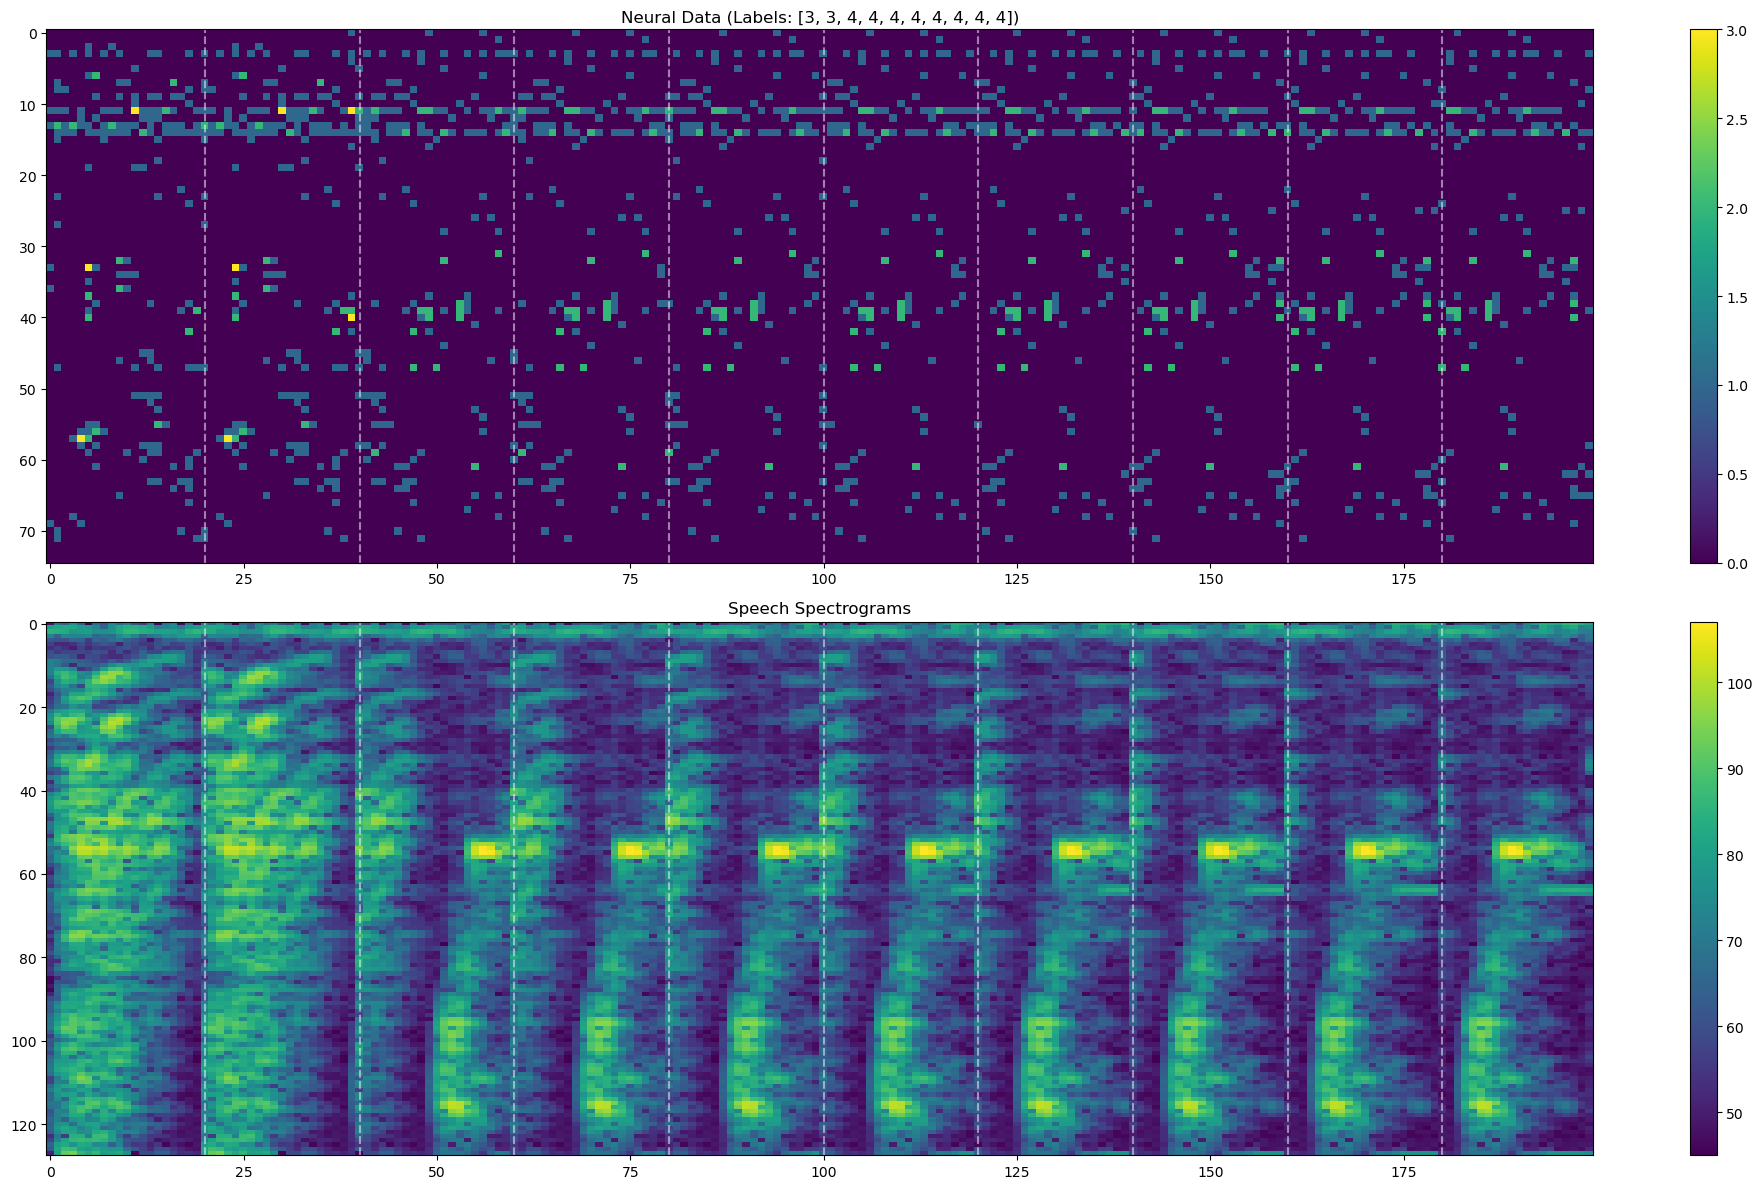

In [25]:
visualize_random_pair(output_dir)